In [1]:
import numpy as np
import re
import pandas as pd
from tqdm.notebook import tqdm
from datasets import load_dataset
import umap
import altair as alt
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from typing import List, Optional
import enum

from langchain_community.llms import Ollama
from langchain.output_parsers.regex_dict import RegexDictParser
from langchain.output_parsers import PydanticOutputParser
from langchain_core.messages import HumanMessage, SystemMessage, ChatMessage
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from pydantic import BaseModel, Field, validator, create_model
from openai import AsyncOpenAI, OpenAI
#import asyncio
import os
from typing import Tuple, List, Optional

import requests

from pydantic import BaseModel, ValidationInfo, model_validator

import json

import itertools
from copy import deepcopy
from tqdm.notebook import tqdm, trange
from sklearn.cluster import KMeans

import umap.umap_ as umap
#import umap
import hdbscan

from src.bubble import *
from src.models import *
from src.utilities import *

Retrieved company Darty : 1707313014508x102198350946437700
Retrieved project Darty_trustpilot : 1707329196900x870734705097005300


In [2]:
types_df = get("Type", constraints=[])
categories_df = get("Category")
original_subcategories_df = get("SubCategory")
aspects_df = get("Aspect")

In [10]:
aspects_df.to_csv("aspects_df.csv")

In [6]:
ID_CATEG_NONE = categories_df[categories_df["Name"].isna()].iloc[0]["_id"]
REAL_CATEGORIES = categories_df[categories_df["_id"] != ID_CATEG_NONE]

In [7]:
import pandas as pd

def global_stats_and_rating_counts(df, interval="M"):
    """
    Calculates various statistics (mean, max, count) and rating counts for each groupby variable
    and interval in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        interval (str, optional): The time interval for grouping. Defaults to "M".
        groupby (str, optional): The column to group by. Defaults to "Category".

    Returns:
        pd.DataFrame: The output DataFrame with additional columns for statistics and rating counts.
    """

    df["Date"] = pd.to_datetime(df["Date"])  # Ensure correct datetime format
    groups = df.groupby(df["Date"].dt.to_period(interval))

    # Calculate mean, max, and total count using agg
    statistics = groups.agg(
        mean_rating=("Rating", "mean"),
        max_rating=("Rating", "max"),
        min_rating=("Rating", "min"),
        median_rating=("Rating", "median"),
        q1_rating = ("Rating", lambda x: np.quantile(x, 0.25)),
        q3_rating = ("Rating", lambda x: np.quantile(x, 0.75)),
        count=("Rating", "count")
    ).reset_index()

    # Calculate rating counts using value_counts() within a loop
    rating_counts = []
    for name, group in groups:
        rating_counts.append(group["Rating"].value_counts().rename(name))

    # Combine rating counts into a single DataFrame
    rating_counts_df = pd.concat(rating_counts, axis=1).fillna(0)

    merged_df = pd.concat([statistics.set_index("Date"), rating_counts_df.T], axis=1)
    # Merge statistics and rating counts
    display_format = "%m/%d/%Y"

    merged_df = merged_df.rename_axis('Date').reset_index()

    merged_df["Date"] = merged_df["Date"].apply(lambda x:x.strftime(display_format))
    merged_df['Date'] = pd.to_datetime(merged_df["Date"])  # Ensure correct datetime format

    if interval == 'W':
        merged_df['Date'] = merged_df['Date'] - pd.to_timedelta(merged_df['Date'].dt.day_of_week, unit='d')
    elif interval == 'M':
        merged_df['Date'] = merged_df['Date'] - pd.to_timedelta(merged_df['Date'].dt.day-1, unit='d')
    elif interval == 'Y':
        merged_df['Date'] = merged_df['Date'] - pd.to_timedelta(merged_df['Date'].dt.day_of_year-1, unit='d')

    merged_df["Date"] = merged_df["Date"].apply(lambda x:x.strftime(display_format))
    #merged_df["Date"] = merged_df["Date"].apply(lambda x:x.to_timestamp(interval))
    merged_df["Period"] = interval
    merged_df["Category"] = ID_CATEG_NONE
    merged_df["SubCategory"] = None
    merged_df["Grouped by"] = None
    return merged_df

# Example usage
df = aspects_df  # Load your DataFrame
#statistics, rating_counts_df = group_stats_and_rating_counts(df)
statistics_and_counts = global_stats_and_rating_counts(df, interval="M")
statistics_and_counts #.head()

/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/338103157.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby(df["Date"].dt.to_period(interval))


,Date,mean_rating,max_rating,min_rating,median_rating,q1_rating,q3_rating,count,5,4,1,2,3,Period,Category,SubCategory,Grouped by
0,11/01/2022,4.500000,5,4,4.5,4.25,4.75,2,1.0,1.0,0.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
1,01/01/2023,5.000000,5,5,5.0,5.00,5.00,1,1.0,0.0,0.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
2,02/01/2023,1.400000,2,1,1.0,1.00,2.00,5,0.0,0.0,3.0,2.0,0.0,M,1709322143530x849396050152903400,None,None
3,03/01/2023,1.000000,1,1,1.0,1.00,1.00,2,0.0,0.0,2.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
4,04/01/2023,1.666667,5,1,1.0,1.00,1.00,12,2.0,0.0,10.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
5,05/01/2023,1.000000,1,1,1.0,1.00,1.00,5,0.0,0.0,5.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
6,06/01/2023,4.000000,5,3,4.0,3.50,4.50,2,1.0,0.0,0.0,0.0,1.0,M,1709322143530x849396050152903400,None,None
7,07/01/2023,2.000000,5,1,1.0,1.00,2.00,8,2.0,0.0,6.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
8,08/01/2023,3.666667,5,1,5.0,2.00,5.00,6,4.0,0.0,2.0,0.0,0.0,M,1709322143530x849396050152903400,None,None
9,09/01/2023,3.387755,5,1,5.0,1.00,5.00,49,25.0,3.0,14.0,6.0,1.0,M,1709322143530x849396050152903400,None,None


In [8]:
import pandas as pd

def group_stats_and_rating_counts(df, interval="M", groupby="Category"):
    """
    Calculates various statistics (mean, max, count) and rating counts for each groupby variable
    and interval in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        interval (str, optional): The time interval for grouping. Defaults to "M".
        groupby (str, optional): The column to group by. Defaults to "Category".

    Returns:
        pd.DataFrame: The output DataFrame with additional columns for statistics and rating counts.
    """
    if groupby is None:
        return global_stats_and_rating_counts(df, interval=interval)

    df["Date"] = pd.to_datetime(df["Date"])  # Ensure correct datetime format
    added_columns = [groupby] if groupby is not None else []
    added_columns += ["Category"] if groupby=="SubCategory" else []
    groups = df.groupby([df["Date"].dt.to_period(interval)]+added_columns)

    # Calculate mean, max, and total count using agg
    statistics = groups.agg(
        mean_rating=("Rating", "mean"),
        max_rating=("Rating", "max"),
        min_rating=("Rating", "min"),
        median_rating=("Rating", "median"),
        q1_rating = ("Rating", lambda x: np.quantile(x, 0.25)),
        q3_rating = ("Rating", lambda x: np.quantile(x, 0.75)),
        count=("Rating", "count")
    ).reset_index()

    # Calculate rating counts using value_counts() within a loop
    rating_counts = []
    for name, group in groups:
        rating_counts.append(group["Rating"].value_counts().rename(name))

    # Combine rating counts into a single DataFrame
    rating_counts_df = pd.concat(rating_counts, axis=1).fillna(0)

    multi_index = ["Date"] + added_columns
    merged_df = pd.concat([statistics.set_index(multi_index), rating_counts_df.T], axis=1)
    # Merge statistics and rating counts
    #merged_df = pd.merge(statistics, rating_counts_df, on=[name[0], groupby])

    #display_format = "%Y"
    #display_format += "-%m" if interval != "Y" else ""
    #display_format += "-%d" if interval != "M" else ""
    display_format = "%m/%d/%Y"

    merged_df = merged_df.reset_index(names=multi_index)

    merged_df["Date"] = merged_df["Date"].apply(lambda x:x.strftime(display_format))
    merged_df['Date'] = pd.to_datetime(merged_df["Date"])  # Ensure correct datetime format

    if interval == 'W':
        merged_df['Date'] = merged_df['Date'] - pd.to_timedelta(merged_df['Date'].dt.day_of_week, unit='d')
    elif interval == 'M':
        merged_df['Date'] = merged_df['Date'] - pd.to_timedelta(merged_df['Date'].dt.day-1, unit='d')
    elif interval == 'Y':
        merged_df['Date'] = merged_df['Date'] - pd.to_timedelta(merged_df['Date'].dt.day_of_year-1, unit='d')

    merged_df["Date"] = merged_df["Date"].apply(lambda x:x.strftime(display_format))
    #merged_df["Date"] = merged_df["Date"].apply(lambda x:x.to_timestamp(interval))
    merged_df["Period"] = interval
    merged_df["Grouped by"] = groupby
    if "SubCategory" not in merged_df:
        merged_df["SubCategory"] = None

    return merged_df

# Example usage
df = aspects_df  # Load your DataFrame
#statistics, rating_counts_df = group_stats_and_rating_counts(df)
statistics_and_counts = group_stats_and_rating_counts(df, interval="M", groupby="Category")
statistics_and_counts #.head()

['Date', 'Category']


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/3959238154.py:22: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  groups = df.groupby([df["Date"].dt.to_period(interval)]+added_columns)


,Date,Category,mean_rating,max_rating,min_rating,median_rating,q1_rating,q3_rating,count,5,4,1,2,3,Period,Grouped by,SubCategory
0,11/01/2022,1709253065849x444427432726514300,5.000000,5,5,5.0,5.00,5.00,1,1.0,0.0,0.0,0.0,0.0,M,Category,None
1,11/01/2022,1709253079053x541586600770979300,4.000000,4,4,4.0,4.00,4.00,1,0.0,1.0,0.0,0.0,0.0,M,Category,None
2,01/01/2023,1709253062423x867774813720628500,5.000000,5,5,5.0,5.00,5.00,1,1.0,0.0,0.0,0.0,0.0,M,Category,None
3,02/01/2023,1709253062423x867774813720628500,1.000000,1,1,1.0,1.00,1.00,2,0.0,0.0,2.0,0.0,0.0,M,Category,None
4,02/01/2023,1709253065849x444427432726514300,1.500000,2,1,1.5,1.25,1.75,2,0.0,0.0,1.0,1.0,0.0,M,Category,None
5,02/01/2023,1709253075821x830225984700473300,2.000000,2,2,2.0,2.00,2.00,1,0.0,0.0,0.0,1.0,0.0,M,Category,None
6,03/01/2023,1709253062423x867774813720628500,1.000000,1,1,1.0,1.00,1.00,1,0.0,0.0,1.0,0.0,0.0,M,Category,None
7,03/01/2023,1709253065849x444427432726514300,1.000000,1,1,1.0,1.00,1.00,1,0.0,0.0,1.0,0.0,0.0,M,Category,None
8,04/01/2023,1709253062423x867774813720628500,1.666667,5,1,1.0,1.00,1.00,6,1.0,0.0,5.0,0.0,0.0,M,Category,None
9,04/01/2023,1709253065849x444427432726514300,2.333333,5,1,1.0,1.00,3.00,3,1.0,0.0,2.0,0.0,0.0,M,Category,None


In [15]:
ID_SUBCATEGS_NONE = list(original_subcategories_df[original_subcategories_df["Name"].isna()]["_id"])
ID_SUBCATEGS_NONE

['1709322250500x203169341028516480',
 '1709328814420x450890791939818430',
 '1709328848587x188405163211254430',
 '1709328868102x298458757093897900',
 '1709328910397x304254700391667300',
 '1709328928783x192547956433171800',
 '1709328948132x195480785182820640']

In [4]:
aspect_evol_df

,Company,Grouped by,Max Rating,Mean Rating,Min Rating,Period,Project,SubCategory,Date,Count of 1s,Count of 2s,Count of 3s,Count of 4s,Count of 5s,Count,Category,Q1 Rating,Median Rating,Q3 Rating,_id
0,1707313014508x102198350946437700,Category,5,5.000000,5,Y,1707329196900x870734705097005300,1709328848587x188405163211254430,2022-01-01 00:00:00+00:00,0,0,0,0,1,1,1709253065849x444427432726514300,5,5,5,1709336176703x363905302893557950
1,1707313014508x102198350946437700,Category,4,4.000000,4,Y,1707329196900x870734705097005300,1709328948132x195480785182820640,2022-01-01 00:00:00+00:00,0,0,0,1,0,1,1709253079053x541586600770979300,4,4,4,1709336176708x441319391785526000
2,1707313014508x102198350946437700,Category,5,3.059891,1,Y,1707329196900x870734705097005300,1709328814420x450890791939818430,2023-01-01 00:00:00+00:00,238,26,12,15,260,551,1709253062423x867774813720628500,5,5,5,1709336176712x279784005880717730
3,1707313014508x102198350946437700,Category,5,3.605791,1,Y,1707329196900x870734705097005300,1709328848587x188405163211254430,2023-01-01 00:00:00+00:00,104,43,17,47,238,449,1709253065849x444427432726514300,5,5,5,1709336176714x865048502600126000
4,1707313014508x102198350946437700,Category,5,4.394495,1,Y,1707329196900x870734705097005300,1709328868102x298458757093897900,2023-01-01 00:00:00+00:00,5,5,6,19,74,109,1709253069102x717430988942903300,5,5,5,1709336176719x656158644196871700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,1707313014508x102198350946437700,NaN,3,1.307692,1,D,1707329196900x870734705097005300,1709322250500x203169341028516480,2024-02-03 00:00:00+00:00,10,2,1,0,0,13,1709322143530x849396050152903400,3,3,3,1709341336508x886421332741120500
2857,1707313014508x102198350946437700,NaN,5,5.000000,5,D,1707329196900x870734705097005300,1709322250500x203169341028516480,2024-02-04 00:00:00+00:00,0,0,0,0,3,3,1709322143530x849396050152903400,5,5,5,1709341336509x127872585762338620
2858,1707313014508x102198350946437700,NaN,1,1.000000,1,D,1707329196900x870734705097005300,1709322250500x203169341028516480,2024-02-05 00:00:00+00:00,8,0,0,0,0,8,1709322143530x849396050152903400,1,1,1,1709341336510x529347350390784200
2859,1707313014508x102198350946437700,NaN,2,1.500000,1,D,1707329196900x870734705097005300,1709322250500x203169341028516480,2024-02-06 00:00:00+00:00,1,1,0,0,0,2,1709322143530x849396050152903400,2,2,2,1709341336511x496319684962781600


In [16]:
df = aspect_evol_df.copy()
df.set_index("Date", drop="True", inplace=True)
df = df[df["Category"]=='1709322143530x849396050152903400']

df = df[df["Period"]=='M']
df

,Company,Grouped by,Max Rating,Mean Rating,Min Rating,Period,Project,SubCategory,Count of 1s,Count of 2s,Count of 3s,Count of 4s,Count of 5s,Count,Category,Q1 Rating,Median Rating,Q3 Rating,_id
Date,,,,,,,,,,,,,,,,,,,
2022-11-01 00:00:00+00:00,1707313014508x102198350946437700,NaN,5,4.500000,4,M,1707329196900x870734705097005300,1709322250500x203169341028516480,0,0,0,1,1,2,1709322143530x849396050152903400,5,5,5,1709341335205x346916525722055000
2023-01-01 00:00:00+00:00,1707313014508x102198350946437700,NaN,5,5.000000,5,M,1707329196900x870734705097005300,1709322250500x203169341028516480,0,0,0,0,1,1,1709322143530x849396050152903400,5,5,5,1709341335206x307680770379303400
2023-02-01 00:00:00+00:00,1707313014508x102198350946437700,NaN,2,1.400000,1,M,1707329196900x870734705097005300,1709322250500x203169341028516480,3,2,0,0,0,5,1709322143530x849396050152903400,2,2,2,1709341335208x162550312809257580
2023-03-01 00:00:00+00:00,1707313014508x102198350946437700,NaN,1,1.000000,1,M,1707329196900x870734705097005300,1709322250500x203169341028516480,2,0,0,0,0,2,1709322143530x849396050152903400,1,1,1,1709341335209x242761857277316040
2023-04-01 00:00:00+00:00,1707313014508x102198350946437700,NaN,5,1.666667,1,M,1707329196900x870734705097005300,1709322250500x203169341028516480,10,0,0,0,2,12,1709322143530x849396050152903400,5,5,5,1709341335211x529602516986820200
2023-05-01 00:00:00+00:00,1707313014508x102198350946437700,NaN,1,1.000000,1,M,1707329196900x870734705097005300,1709322250500x203169341028516480,5,0,0,0,0,5,1709322143530x849396050152903400,1,1,1,1709341335212x959807563111761800
2023-06-01 00:00:00+00:00,1707313014508x102198350946437700,NaN,5,4.000000,3,M,1707329196900x870734705097005300,1709322250500x203169341028516480,0,0,1,0,1,2,1709322143530x849396050152903400,5,5,5,1709341335213x193077752752467870
2023-07-01 00:00:00+00:00,1707313014508x102198350946437700,NaN,5,2.000000,1,M,1707329196900x870734705097005300,1709322250500x203169341028516480,6,0,0,0,2,8,1709322143530x849396050152903400,5,5,5,1709341335215x983526242155879400
2023-08-01 00:00:00+00:00,1707313014508x102198350946437700,NaN,5,3.666667,1,M,1707329196900x870734705097005300,1709322250500x203169341028516480,2,0,0,0,4,6,1709322143530x849396050152903400,5,5,5,1709341335216x921238091482543400


<Axes: xlabel='Date'>

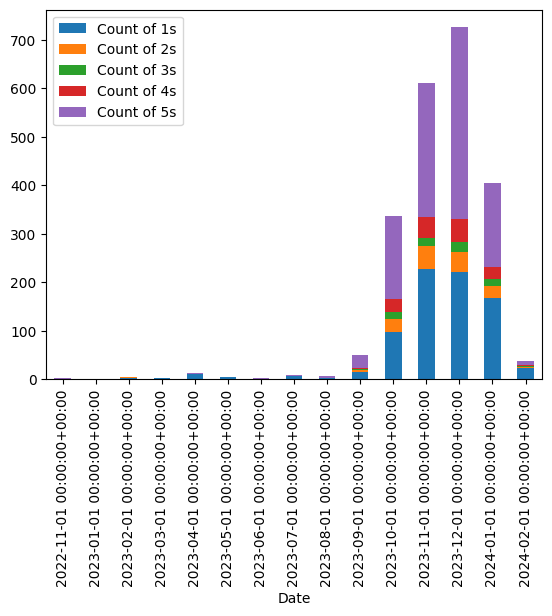

In [22]:
df[[f"Count of {i}s" for i in range(1,6)]].plot(kind='bar', stacked=True)

In [28]:
df = aspect_evol_df.copy()
df = df[df["Period"]=='M']
df = df[df["Grouped by"]=='Category']

df.set_index(["Date", "Category"])

Company  \
Date                      Category                                                             
2022-11-01 00:00:00+00:00 1709253065849x444427432726514300  1707313014508x102198350946437700   
                          1709253079053x541586600770979300  1707313014508x102198350946437700   
2023-01-01 00:00:00+00:00 1709253062423x867774813720628500  1707313014508x102198350946437700   
2023-02-01 00:00:00+00:00 1709253062423x867774813720628500  1707313014508x102198350946437700   
                          1709253065849x444427432726514300  1707313014508x102198350946437700   
                          1709253075821x830225984700473300  1707313014508x102198350946437700   
2023-03-01 00:00:00+00:00 1709253062423x867774813720628500  1707313014508x102198350946437700   
                          1709253065849x444427432726514300  1707313014508x102198350946437700   
2023-04-01 00:00:00+00:00 1709253062423x867774813720628500  1707313014508x102198350946437700   
                          1709253065849x444427432726514300  1707313014508x102198350946437700   
                          1709253072455x374665745287587650  1707313014508x102198350946437700   
                          1709253075821x830225984700473300  1707313014508x102198350946437700   
2023-05-01 00:00:00+00:00 1709253062423x867774813720628500  1707313014508x102198350946437700   
                          1709253065849x444427432726514300  1707313014508x102198350946437700   
                          1709253075821x830225984700473300  1707313014508x102198350946437700   
2023-06-01 00:00:00+00:00 1709253062423x867774813720628500  1707313014508x102198350946437700   
                          1709253069102x717430988942903300  1707313014508x102198350946437700   
2023-07-01 00:00:00+00:00 1709253062423x867774813720628500  1707313014508x102198350946437700   
                          1709253065849x444427432726514300  1707313014508x102198350946437700   
                          1709253075821x830225984700473300  1707313014508x102198350946437700   
                          1709253079053x541586600770979300  1707313014508x102198350946437700   
2023-08-01 00:00:00+00:00 1709253062423x867774813720628500  1707313014508x102198350946437700   
                          1709253065849x444427432726514300  1707313014508x102198350946437700   
2023-09-01 00:00:00+00:00 1709253062423x867774813720628500  1707313014508x102198350946437700   
                          1709253065849x444427432726514300  1707313014508x102198350946437700   
                          1709253069102x717430988942903300  1707313014508x102198350946437700   
                          1709253072455x374665745287587650  1707313014508x102198350946437700   
                          1709253075821x830225984700473300  1707313014508x102198350946437700   
                          1709253079053x541586600770979300  1707313014508x102198350946437700   
2023-10-01 00:00:00+00:00 1709253062423x867774813720628500  1707313014508x102198350946437700   
                          1709253065849x444427432726514300  1707313014508x102198350946437700   
                          1709253069102x717430988942903300  1707313014508x102198350946437700   
                          1709253072455x374665745287587650  1707313014508x102198350946437700   
                          1709253075821x830225984700473300  1707313014508x102198350946437700   
                          1709253079053x541586600770979300  1707313014508x102198350946437700   
2023-11-01 00:00:00+00:00 1709253062423x867774813720628500  1707313014508x102198350946437700   
                          1709253065849x444427432726514300  1707313014508x102198350946437700   
                          1709253069102x717430988942903300  1707313014508x102198350946437700   
                          1709253072455x374665745287587650  1707313014508x102198350946437700   
                          1709253075821x830225984700473300  1707313014508x102198350946437700   
                          1709253079053x5415866007709

In [20]:
aspects_df

,Company,Project,Rating,SubCategory,Associated_feedback,Date,Category,_id,Explanation
0,1707313014508x102198350946437700,1707329196900x870734705097005300,5,1709253069790x305647624075015900,1707643040311x281208184060071520,2024-02-07 00:00:00+00:00,1709253069102x717430988942903300,1709288669731x792381451006279400,NaN
1,1707313014508x102198350946437700,1707329196900x870734705097005300,5,1709253063096x594485916638931600,1707643040311x281208184060071520,2024-02-07 00:00:00+00:00,1709253062423x867774813720628500,1709288669735x628249787027423700,NaN
2,1707313014508x102198350946437700,1707329196900x870734705097005300,5,1709253066544x770991303066428400,1707643040311x281208184060071520,2024-02-07 00:00:00+00:00,1709253065849x444427432726514300,1709288669739x307796151670405300,La touche Touch ID permet de s'authentifier ra...
3,1707313014508x102198350946437700,1707329196900x870734705097005300,3,1709253068464x983179727881815700,1707643040311x281208184060071520,2024-02-07 00:00:00+00:00,1709253065849x444427432726514300,1709288669741x932504918890495000,"Le prix est élevé, comme pour tous les produit..."
4,1707313014508x102198350946437700,1707329196900x870734705097005300,5,1709253077078x822788218820358100,1707643040316x844188021545895200,2024-01-31 00:00:00+00:00,1709253075821x830225984700473300,1709288671136x151764047078959840,La prise en charge de l'installation de la mac...
...,...,...,...,...,...,...,...,...,...
2202,1707313014508x102198350946437700,1707329196900x870734705097005300,1,1709253064382x227766121950602430,1707643051258x374538859254433860,2023-10-21 00:00:00+00:00,1709253062423x867774813720628500,1709290003979x187358384636157500,Le conseiller n'a pas su proposer une solution...
2203,1707313014508x102198350946437700,1707329196900x870734705097005300,5,1709253076447x308401889339217700,1707643051261x530659398374961660,2023-10-05 00:00:00+00:00,1709253075821x830225984700473300,1709290005459x931272324303185500,NaN
2204,1707313014508x102198350946437700,1707329196900x870734705097005300,5,1709253066544x770991303066428400,1707643051261x530659398374961660,2023-10-05 00:00:00+00:00,1709253065849x444427432726514300,1709290005472x763865961084115600,NaN
2205,1707313014508x102198350946437700,1707329196900x870734705097005300,1,1709253078419x303428894799921100,1707643051261x530659398374961660,2023-10-05 00:00:00+00:00,1709253075821x830225984700473300,1709290005476x395899141293267300,Le vendeur a induit le client en erreur concer...


In [28]:
import pandas as pd


import pandas as pd


import pandas as pd


def analyze_feedback_by_period(df, company, category, subcategory, period):
  """Analyzes customer feedback by company, category, subcategory, and period.

  Args:
      df: A pandas DataFrame containing the customer feedback data.
      company: The company to filter by.
      category: The category to filter by.
      subcategory: The subcategory to filter by.
      period: The desired period for grouping the data (e.g., "D" for day, "W" for week).

  Returns:
      A pandas DataFrame with the following columns:
          * Date: The index of the DataFrame, containing the dates for each period.
          * count: The number of customer feedback entries for each period.
  """

  # Filter the DataFrame by the specified criteria
  filtered_df = df[
      (df["Company"] == company)
      & (df["Category"] == category)
      & (df["SubCategory"] == subcategory)
  ]

  explanations = list(filtered_df["Explanation"][filtered_df["Explanation"].notna()])

  # Convert the "Date" column to datetime format
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])

  # Resample the data by the specified period and count the occurrences
  return (
      filtered_df.set_index("Date")
      .resample(period)
      .size()
      .to_frame(name="count")
      .reset_index(), explanations
  )


aspects_df
result, explanations = analyze_feedback_by_period(
    df=aspects_df,
    company="1707313014508x102198350946437700",
    category="1709253069102x717430988942903300",
    subcategory="1709253069790x305647624075015900",
    period="M",
)
result

/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/479812584.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/479812584.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(period)


,Date,count
0,2023-06-30 00:00:00+00:00,1
1,2023-07-31 00:00:00+00:00,0
2,2023-08-31 00:00:00+00:00,0
3,2023-09-30 00:00:00+00:00,2
4,2023-10-31 00:00:00+00:00,18
5,2023-11-30 00:00:00+00:00,20
6,2023-12-31 00:00:00+00:00,18
7,2024-01-31 00:00:00+00:00,8
8,2024-02-29 00:00:00+00:00,1


In [34]:
import pandas as pd


def analyze_feedback_by_period(df, company, category, subcategory, period):
  """Analyzes customer feedback by company, category, subcategory, and period.

  Args:
      df: A pandas DataFrame containing the customer feedback data.
      company: The company to filter by.
      category: The category to filter by.
      subcategory: The subcategory to filter by.
      period: The desired period for grouping the data (e.g., "D" for day, "W" for week, "M" for month, "Y" for year).

  Returns:
      A pandas DataFrame with the following columns:
          * Date: The index of the DataFrame, containing the dates formatted according to the period.
          * count: The number of customer feedback entries for each period.
          * ... (similar columns for rating counts, mean, and standard deviation)
  """

  # Filter the DataFrame by the specified criteria
  filtered_df = df[
      (df["Company"] == company)
      & (df["Category"] == category)
      & (df["SubCategory"] == subcategory)
  ]

  # Handle cases where no data matches the filter
  if filtered_df.empty:
    return pd.DataFrame({
        "Date": [],
        "count": [],
        "rating_1": [],
        "rating_2": [],
        "rating_3": [],
        "rating_4": [],
        "rating_5": [],
        "mean": [],
        "std": [],
    })

  # Convert the "Date" column to datetime format
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])

  # Define date format function based on period
  def format_date(date, period):
    if period == "D":
      return date.strftime("%d/%m/%Y")
    elif period == "W":
      return date.strftime("%U-%Y")  # Week format with year, e.g., 01-2024
    elif period == "M":
      return date.strftime("%m/%Y")
    else:
      return date.strftime("%Y")

  # Resample the data by the specified period, aggregating on various columns
  grouped_data = (
      filtered_df.set_index("Date")
      .resample(period)
      .agg(
          count=("Rating", "count"),
          rating_1=("Rating", lambda x: x[x == 1].count()),
          rating_2=("Rating", lambda x: x[x == 2].count()),
          rating_3=("Rating", lambda x: x[x == 3].count()),
          rating_4=("Rating", lambda x: x[x == 4].count()),
          rating_5=("Rating", lambda x: x[x == 5].count()),
          mean=("Rating", "mean"),
          std=("Rating", "std"),
      )
      .reset_index()
  )

  # Apply date formatting based on period
  grouped_data["Date"] = grouped_data["Date"].apply(
      lambda x: format_date(x, period)
  )

  # Fill missing values with 0
  grouped_data = grouped_data.fillna(0)

  return grouped_data



analyze_feedback_by_period(
    df=aspects_df,
    company="1707313014508x102198350946437700",
    category="1709253069102x717430988942903300",
    subcategory="1709253069790x305647624075015900",
    period="M",
)

/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/419390337.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/419390337.py:59: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(period)


,Date,count,rating_1,rating_2,rating_3,rating_4,rating_5,mean,std
0,06/2023,1,0,0,1,0,0,3.000000,0.000000
1,07/2023,0,0,0,0,0,0,0.000000,0.000000
2,08/2023,0,0,0,0,0,0,0.000000,0.000000
3,09/2023,2,0,1,0,0,1,3.500000,2.121320
4,10/2023,18,1,0,1,5,11,4.388889,1.036901
5,11/2023,20,0,2,1,5,12,4.350000,0.988087
6,12/2023,18,1,0,1,3,13,4.500000,1.043185
7,01/2024,8,2,0,1,2,3,3.500000,1.690309
8,02/2024,1,0,0,0,0,1,5.000000,0.000000


In [171]:
import pandas as pd


def analyze_feedback_by_period(df, company, category, subcategory, period):
  """Analyzes customer feedback by company, category, subcategory, and period.

  Args:
      df: A pandas DataFrame containing the customer feedback data.
      company: The company to filter by.
      category: The category to filter by.
      subcategory: The subcategory to filter by.
      period: The desired period for grouping the data (e.g., "D" for day, "W" for week, "M" for month, "Y" for year).

  Returns:
      A pandas DataFrame with the following columns:
          * Date: The index of the DataFrame, containing the dates formatted according to the period, 
                  starting from the minimum date of the entire DataFrame.
          * count: The number of customer feedback entries for each period (0 if no entries).
          * ... (similar columns for rating counts, mean, and standard deviation)
          
      The min and std columns will have None values for periods with no entries.
  """

  # Get the minimum date from the entire DataFrame
  min_date = df["Date"].min()

  # Filter the DataFrame by the specified criteria
  filtered_df = df[
      (df["Company"] == company)
      & (df["Category"] == category)
      & (df["SubCategory"] == subcategory)
  ]

  # Handle cases where no data matches the filter
  if filtered_df.empty:
    res_df = pd.DataFrame({
        "Date": pd.date_range(start=min_date, periods=0, freq=period)})
    res_df["count"]= 0
    res_df["rating_1"]= 0
    res_df["rating_2"]= 0
    res_df["rating_3"]= 0
    res_df["rating_4"]= 0
    res_df["rating_5"]= 0
    res_df["min"]= 0
    res_df["max"]= 0
    res_df["mean"]= 0
    res_df["std"]= 0
    res_df["median"]= 0
    res_df["q1"]= 0
    res_df["q3"]= 0
    res_df["Date Display"] = res_df["Date"].apply(
      lambda x: format_date(x, period)
  )
    return res_df
  
  # Convert the "Date" column to datetime format
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])

  # Define date format function based on period
  def format_date(date, period):
    if period == "D":
      return date.strftime("%d/%m/%Y")
    elif period == "W":
      return date.strftime("%U-%Y")  # Week format with year, e.g., 01-2024
    elif period == "M":
      return date.strftime("%m/%Y")
    else:
      return date.strftime("%Y")

  # Resample the data by the specified period, aggregating on various columns
  grouped_data = (
      filtered_df.set_index("Date")
      .resample(period)
      .agg(
          count=("Rating", "count"),
          rating_1=("Rating", lambda x: x[x == 1].count()),
          rating_2=("Rating", lambda x: x[x == 2].count()),
          rating_3=("Rating", lambda x: x[x == 3].count()),
          rating_4=("Rating", lambda x: x[x == 4].count()),
          rating_5=("Rating", lambda x: x[x == 5].count()),
          mean=("Rating", "mean"),
          std=("Rating", "std"),
          median=("Rating", "median"),
          min=("Rating", "min"),
          max=("Rating", "max"),
          q1=("Rating", lambda x: x.quantile(0.25)),
          q3=("Rating", lambda x: x.quantile(0.75)),
      )
      .reset_index()
  )

  
  # Set the minimum date from entire DataFrame as the starting index
  grouped_data.set_index("Date", inplace=True)
  # Create a date range with appropriate length based on min and max dates of filtered data
  date_range = pd.date_range(
      start=min_date, end=filtered_df["Date"].max(), freq=period
  )

  # Reindex to fill missing periods with 0 and None for mean/std
  grouped_data = grouped_data.reindex(date_range).fillna(0)

  # Fill missing values with appropriate values
  grouped_data.loc[:, "count"] = grouped_data["count"].fillna(0)
  grouped_data.loc[grouped_data["count"] == 0, ["mean", "std", "median", "min", "max", "q1", "q3"]] = None

  grouped_data = grouped_data.rename_axis('Date').reset_index()

  # Apply date formatting based on period
  grouped_data["Date Display"] = grouped_data["Date"].apply(
      lambda x: format_date(x, period)
  )
  return grouped_data


In [165]:
df = analyze_feedback_by_period(
    df=aspects_df,
    company="1707313014508x102198350946437700",
    category="1709253069102x717430988942903300",
    subcategory="1709253069790x305647624075015900",
    period="M",
)
df

/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/2398520486.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/2398520486.py:70: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(period)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/2398520486.py:93: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(


,Date,count,rating_1,rating_2,rating_3,rating_4,rating_5,mean,std,median,min,max,q1,q3,Date Display
0,2022-11-30 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11/2022
1,2022-12-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12/2022
2,2023-01-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/2023
3,2023-02-28 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,02/2023
4,2023-03-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03/2023
5,2023-04-30 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04/2023
6,2023-05-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05/2023
7,2023-06-30 00:00:00+00:00,1.0,0.0,0.0,1.0,0.0,0.0,3.000000,0.000000,3.0,3.0,3.0,3.00,3.00,06/2023
8,2023-07-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07/2023
9,2023-08-31 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08/2023


In [172]:
def to_list(s):
    return [0 if pd.isna(x) else x for x in s]

def send_aspects(df, company, category, subcategory, period, grouped_by=None):
    d = {
        "Company": company,
        "Project": PROJECT_ID,
        "Category": category,
        "SubCategory": subcategory,
        "Period": period,
        "Grouped by": grouped_by,
        "Counts": to_list(df["count"]),
        "Counts of 1s": to_list(df["rating_1"]),
        "Counts of 2s": to_list(df["rating_2"]),
        "Counts of 3s": to_list(df["rating_3"]),
        "Counts of 4s": to_list(df["rating_4"]),
        "Counts of 5s": to_list(df["rating_5"]),
        "Dates": to_list(df["Date"].apply(lambda x:pd.to_datetime(x).strftime("%m/%d/%Y"))), #
        "Dates Display": to_list(df["Date Display"]),
        "Max Ratings": to_list(df["min"]),
        "Mean Ratings": to_list(df["mean"]),
        "Std Ratings": to_list(df["std"]),
        "Med Ratings": to_list(df["median"]),
        "Min Ratings": to_list(df["max"]),
        "Q1 Rating": to_list(df["q1"]),
        "Q3 Rating": to_list(df["q3"]),
        }  

    bubble_id = bubble_client.create("Aspect Evol",d)
    return bubble_id

In [173]:
aspects_df

,Company,Project,Rating,SubCategory,Associated_feedback,Date,Category,_id,Explanation
0,1707313014508x102198350946437700,1707329196900x870734705097005300,5,1709253069790x305647624075015900,1707643040311x281208184060071520,2024-02-07 00:00:00+00:00,1709253069102x717430988942903300,1709288669731x792381451006279400,NaN
1,1707313014508x102198350946437700,1707329196900x870734705097005300,5,1709253063096x594485916638931600,1707643040311x281208184060071520,2024-02-07 00:00:00+00:00,1709253062423x867774813720628500,1709288669735x628249787027423700,NaN
2,1707313014508x102198350946437700,1707329196900x870734705097005300,5,1709253066544x770991303066428400,1707643040311x281208184060071520,2024-02-07 00:00:00+00:00,1709253065849x444427432726514300,1709288669739x307796151670405300,La touche Touch ID permet de s'authentifier ra...
3,1707313014508x102198350946437700,1707329196900x870734705097005300,3,1709253068464x983179727881815700,1707643040311x281208184060071520,2024-02-07 00:00:00+00:00,1709253065849x444427432726514300,1709288669741x932504918890495000,"Le prix est élevé, comme pour tous les produit..."
4,1707313014508x102198350946437700,1707329196900x870734705097005300,5,1709253077078x822788218820358100,1707643040316x844188021545895200,2024-01-31 00:00:00+00:00,1709253075821x830225984700473300,1709288671136x151764047078959840,La prise en charge de l'installation de la mac...
...,...,...,...,...,...,...,...,...,...
2202,1707313014508x102198350946437700,1707329196900x870734705097005300,1,1709253064382x227766121950602430,1707643051258x374538859254433860,2023-10-21 00:00:00+00:00,1709253062423x867774813720628500,1709290003979x187358384636157500,Le conseiller n'a pas su proposer une solution...
2203,1707313014508x102198350946437700,1707329196900x870734705097005300,5,1709253076447x308401889339217700,1707643051261x530659398374961660,2023-10-05 00:00:00+00:00,1709253075821x830225984700473300,1709290005459x931272324303185500,NaN
2204,1707313014508x102198350946437700,1707329196900x870734705097005300,5,1709253066544x770991303066428400,1707643051261x530659398374961660,2023-10-05 00:00:00+00:00,1709253065849x444427432726514300,1709290005472x763865961084115600,NaN
2205,1707313014508x102198350946437700,1707329196900x870734705097005300,1,1709253078419x303428894799921100,1707643051261x530659398374961660,2023-10-05 00:00:00+00:00,1709253075821x830225984700473300,1709290005476x395899141293267300,Le vendeur a induit le client en erreur concer...


In [174]:
for category in categories_df["_id"]:
    for subcategory in original_subcategories_df["_id"]:
        for period in ["W", "M", "Y"]:
            df = analyze_feedback_by_period(aspects_df, COMPANY_ID, category, subcategory, period)
            send_aspects(df, COMPANY_ID, category, subcategory, period)

/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])


0    2022-11-27 00:00:00+00:00
1    2022-12-04 00:00:00+00:00
2    2022-12-11 00:00:00+00:00
3    2022-12-18 00:00:00+00:00
4    2022-12-25 00:00:00+00:00
                ...           
58   2024-01-07 00:00:00+00:00
59   2024-01-14 00:00:00+00:00
60   2024-01-21 00:00:00+00:00
61   2024-01-28 00:00:00+00:00
62   2024-02-04 00:00:00+00:00
Name: Date, Length: 63, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(period)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:96: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(


0    2022-11-30 00:00:00+00:00
1    2022-12-31 00:00:00+00:00
2    2023-01-31 00:00:00+00:00
3    2023-02-28 00:00:00+00:00
4    2023-03-31 00:00:00+00:00
5    2023-04-30 00:00:00+00:00
6    2023-05-31 00:00:00+00:00
7    2023-06-30 00:00:00+00:00
8    2023-07-31 00:00:00+00:00
9    2023-08-31 00:00:00+00:00
10   2023-09-30 00:00:00+00:00
11   2023-10-31 00:00:00+00:00
12   2023-11-30 00:00:00+00:00
13   2023-12-31 00:00:00+00:00
14   2024-01-31 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:73: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample(period)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:96: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  date_range = pd.date_range(


0   2022-12-31 00:00:00+00:00
1   2023-12-31 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])


0    2022-11-27 00:00:00+00:00
1    2022-12-04 00:00:00+00:00
2    2022-12-11 00:00:00+00:00
3    2022-12-18 00:00:00+00:00
4    2022-12-25 00:00:00+00:00
                ...           
57   2023-12-31 00:00:00+00:00
58   2024-01-07 00:00:00+00:00
59   2024-01-14 00:00:00+00:00
60   2024-01-21 00:00:00+00:00
61   2024-01-28 00:00:00+00:00
Name: Date, Length: 62, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(period)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:96: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(


0    2022-11-30 00:00:00+00:00
1    2022-12-31 00:00:00+00:00
2    2023-01-31 00:00:00+00:00
3    2023-02-28 00:00:00+00:00
4    2023-03-31 00:00:00+00:00
5    2023-04-30 00:00:00+00:00
6    2023-05-31 00:00:00+00:00
7    2023-06-30 00:00:00+00:00
8    2023-07-31 00:00:00+00:00
9    2023-08-31 00:00:00+00:00
10   2023-09-30 00:00:00+00:00
11   2023-10-31 00:00:00+00:00
12   2023-11-30 00:00:00+00:00
13   2023-12-31 00:00:00+00:00
14   2024-01-31 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:73: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample(period)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:96: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  date_range = pd.date_range(


0   2022-12-31 00:00:00+00:00
1   2023-12-31 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])


0    2022-11-27 00:00:00+00:00
1    2022-12-04 00:00:00+00:00
2    2022-12-11 00:00:00+00:00
3    2022-12-18 00:00:00+00:00
4    2022-12-25 00:00:00+00:00
                ...           
58   2024-01-07 00:00:00+00:00
59   2024-01-14 00:00:00+00:00
60   2024-01-21 00:00:00+00:00
61   2024-01-28 00:00:00+00:00
62   2024-02-04 00:00:00+00:00
Name: Date, Length: 63, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(period)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:96: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(


0    2022-11-30 00:00:00+00:00
1    2022-12-31 00:00:00+00:00
2    2023-01-31 00:00:00+00:00
3    2023-02-28 00:00:00+00:00
4    2023-03-31 00:00:00+00:00
5    2023-04-30 00:00:00+00:00
6    2023-05-31 00:00:00+00:00
7    2023-06-30 00:00:00+00:00
8    2023-07-31 00:00:00+00:00
9    2023-08-31 00:00:00+00:00
10   2023-09-30 00:00:00+00:00
11   2023-10-31 00:00:00+00:00
12   2023-11-30 00:00:00+00:00
13   2023-12-31 00:00:00+00:00
14   2024-01-31 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:73: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample(period)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:96: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  date_range = pd.date_range(


0   2022-12-31 00:00:00+00:00
1   2023-12-31 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])


0    2022-11-27 00:00:00+00:00
1    2022-12-04 00:00:00+00:00
2    2022-12-11 00:00:00+00:00
3    2022-12-18 00:00:00+00:00
4    2022-12-25 00:00:00+00:00
                ...           
57   2023-12-31 00:00:00+00:00
58   2024-01-07 00:00:00+00:00
59   2024-01-14 00:00:00+00:00
60   2024-01-21 00:00:00+00:00
61   2024-01-28 00:00:00+00:00
Name: Date, Length: 62, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(period)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:96: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(


0    2022-11-30 00:00:00+00:00
1    2022-12-31 00:00:00+00:00
2    2023-01-31 00:00:00+00:00
3    2023-02-28 00:00:00+00:00
4    2023-03-31 00:00:00+00:00
5    2023-04-30 00:00:00+00:00
6    2023-05-31 00:00:00+00:00
7    2023-06-30 00:00:00+00:00
8    2023-07-31 00:00:00+00:00
9    2023-08-31 00:00:00+00:00
10   2023-09-30 00:00:00+00:00
11   2023-10-31 00:00:00+00:00
12   2023-11-30 00:00:00+00:00
13   2023-12-31 00:00:00+00:00
14   2024-01-31 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:73: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample(period)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:96: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  date_range = pd.date_range(


0   2022-12-31 00:00:00+00:00
1   2023-12-31 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])


0    2022-11-27 00:00:00+00:00
1    2022-12-04 00:00:00+00:00
2    2022-12-11 00:00:00+00:00
3    2022-12-18 00:00:00+00:00
4    2022-12-25 00:00:00+00:00
                ...           
58   2024-01-07 00:00:00+00:00
59   2024-01-14 00:00:00+00:00
60   2024-01-21 00:00:00+00:00
61   2024-01-28 00:00:00+00:00
62   2024-02-04 00:00:00+00:00
Name: Date, Length: 63, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(period)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:96: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(


0    2022-11-30 00:00:00+00:00
1    2022-12-31 00:00:00+00:00
2    2023-01-31 00:00:00+00:00
3    2023-02-28 00:00:00+00:00
4    2023-03-31 00:00:00+00:00
5    2023-04-30 00:00:00+00:00
6    2023-05-31 00:00:00+00:00
7    2023-06-30 00:00:00+00:00
8    2023-07-31 00:00:00+00:00
9    2023-08-31 00:00:00+00:00
10   2023-09-30 00:00:00+00:00
11   2023-10-31 00:00:00+00:00
12   2023-11-30 00:00:00+00:00
13   2023-12-31 00:00:00+00:00
14   2024-01-31 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:73: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample(period)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:96: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  date_range = pd.date_range(


0   2022-12-31 00:00:00+00:00
1   2023-12-31 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])


0    2022-11-27 00:00:00+00:00
1    2022-12-04 00:00:00+00:00
2    2022-12-11 00:00:00+00:00
3    2022-12-18 00:00:00+00:00
4    2022-12-25 00:00:00+00:00
                ...           
58   2024-01-07 00:00:00+00:00
59   2024-01-14 00:00:00+00:00
60   2024-01-21 00:00:00+00:00
61   2024-01-28 00:00:00+00:00
62   2024-02-04 00:00:00+00:00
Name: Date, Length: 63, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(period)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:96: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(


0    2022-11-30 00:00:00+00:00
1    2022-12-31 00:00:00+00:00
2    2023-01-31 00:00:00+00:00
3    2023-02-28 00:00:00+00:00
4    2023-03-31 00:00:00+00:00
5    2023-04-30 00:00:00+00:00
6    2023-05-31 00:00:00+00:00
7    2023-06-30 00:00:00+00:00
8    2023-07-31 00:00:00+00:00
9    2023-08-31 00:00:00+00:00
10   2023-09-30 00:00:00+00:00
11   2023-10-31 00:00:00+00:00
12   2023-11-30 00:00:00+00:00
13   2023-12-31 00:00:00+00:00
14   2024-01-31 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:73: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample(period)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:96: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  date_range = pd.date_range(


0   2022-12-31 00:00:00+00:00
1   2023-12-31 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])


0    2022-11-27 00:00:00+00:00
1    2022-12-04 00:00:00+00:00
2    2022-12-11 00:00:00+00:00
3    2022-12-18 00:00:00+00:00
4    2022-12-25 00:00:00+00:00
                ...           
56   2023-12-24 00:00:00+00:00
57   2023-12-31 00:00:00+00:00
58   2024-01-07 00:00:00+00:00
59   2024-01-14 00:00:00+00:00
60   2024-01-21 00:00:00+00:00
Name: Date, Length: 61, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(period)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:96: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(


0    2022-11-30 00:00:00+00:00
1    2022-12-31 00:00:00+00:00
2    2023-01-31 00:00:00+00:00
3    2023-02-28 00:00:00+00:00
4    2023-03-31 00:00:00+00:00
5    2023-04-30 00:00:00+00:00
6    2023-05-31 00:00:00+00:00
7    2023-06-30 00:00:00+00:00
8    2023-07-31 00:00:00+00:00
9    2023-08-31 00:00:00+00:00
10   2023-09-30 00:00:00+00:00
11   2023-10-31 00:00:00+00:00
12   2023-11-30 00:00:00+00:00
13   2023-12-31 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:73: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample(period)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:96: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  date_range = pd.date_range(


0   2022-12-31 00:00:00+00:00
1   2023-12-31 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])


0    2022-11-27 00:00:00+00:00
1    2022-12-04 00:00:00+00:00
2    2022-12-11 00:00:00+00:00
3    2022-12-18 00:00:00+00:00
4    2022-12-25 00:00:00+00:00
                ...           
58   2024-01-07 00:00:00+00:00
59   2024-01-14 00:00:00+00:00
60   2024-01-21 00:00:00+00:00
61   2024-01-28 00:00:00+00:00
62   2024-02-04 00:00:00+00:00
Name: Date, Length: 63, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(period)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:96: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(


0    2022-11-30 00:00:00+00:00
1    2022-12-31 00:00:00+00:00
2    2023-01-31 00:00:00+00:00
3    2023-02-28 00:00:00+00:00
4    2023-03-31 00:00:00+00:00
5    2023-04-30 00:00:00+00:00
6    2023-05-31 00:00:00+00:00
7    2023-06-30 00:00:00+00:00
8    2023-07-31 00:00:00+00:00
9    2023-08-31 00:00:00+00:00
10   2023-09-30 00:00:00+00:00
11   2023-10-31 00:00:00+00:00
12   2023-11-30 00:00:00+00:00
13   2023-12-31 00:00:00+00:00
14   2024-01-31 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Date"] = pd.to_datetime(filtered_df["Date"])
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:73: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample(period)
/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:96: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  date_range = pd.date_range(


0   2022-12-31 00:00:00+00:00
1   2023-12-31 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])


/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_39802/4015186877.py:37: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Date": pd.date_range(start=min_date, periods=0, freq=period)})


Series([], Name: Date, dtype: datetime64[ns, UTC])
Series([], Name: Date, dtype: datetime64[ns, UTC])


In [143]:
# Example list with NaN values
data_list = [1, 2, 3, None, 5]

# Remove NaN values using list comprehension
filtered_list = [x for x in data_list if not pd.isna(x)]

# Alternatively, use pandas functions
import pandas as pd

data_list = pd.Series(data_list)
filtered_list = data_list.dropna().tolist()

# Now, send "filtered_list" to the Bubble API
filtered_list

[1.0, 2.0, 3.0, 5.0]